In [1]:
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import torch
from cal_loss_batch import cal_loss_batch_all_variant
from Deterministic_T_stage_AC_Opf_SOCP import Conduct_Deterministic_T_stage_OPF
import copy

In [2]:
Filepath='./data/case33.mat'
data=io.loadmat(Filepath)
ppc=data['mpc']
ppc_try=copy.deepcopy(ppc)

### ramping information
ramp_rate=0.7
Generators = np.array(ppc["gen"][0,0])
Pmax=8
Pmin=9
Initial_Pmax=Generators[0:5,Pmax]



### demand response
### append to generators
Buses= np.array(ppc["bus"][0,0])
Pd=2
DR_loc=[22, 29, 33, 25, 14, 18]
Gen_new=[]
Gen_cost=[]
for dr in DR_loc:
    # dr_p_max=Buses[dr-1,Pd]/3
    dr_p_max=0.01
    dr_q_limit=0.01
    dr_list = [dr,	0,	0,	dr_q_limit ,    -dr_q_limit  ,  1	,1000	,1  , dr_p_max ,	0]
    dr_cost = [2,	0,	0,	3,	0,	10.0,	0]
    Gen_new.append(dr_list)
    Gen_cost.append(dr_cost)

# ppc["gen"][0,0].append(Gen_new)
a_rep = np.concatenate([ppc["gen"][0,0], Gen_new], axis=0)
ppc["gen"][0,0] = a_rep
a_rep = np.concatenate([ppc_try["gen"][0,0], Gen_new], axis=0)
ppc_try["gen"][0,0] = a_rep
# print(ppc["gen"][0,0].shape,a_rep.shape)
# print(ppc["gen"][0,0])

a_rep = np.concatenate([ppc["gencost"][0,0], Gen_cost], axis=0)
ppc["gencost"][0,0] = a_rep
a_rep = np.concatenate([ppc_try["gencost"][0,0], Gen_cost], axis=0)
ppc_try["gencost"][0,0] = a_rep
# print(ppc["gencost"][0,0].shape,a_rep.shape)
# print(ppc["gencost"][0,0])

### storage information
# location
BA_loc=[19,26,23,12]
SOC_last_solve=0.5*np.ones((1,4))
Gen_new=[]
Gen_cost=[]
Gen_new_try=[]
for ii in range(len(BA_loc)):
    ba=BA_loc[ii]
    BA_cap=1.0
    BA_limit=0.5
    # output bound DIS_limit p_b Ch_limit
    # state change SOC_new =SOC_last_solve - p_b, need to return
    # capacity 0 < SOC_new< soc_cap
    BA_MIN=np.max(np.array([-BA_limit, -(BA_cap-SOC_last_solve[0,ii])]), axis=0)
    BA_MAX=np.min(np.array([BA_limit, SOC_last_solve[0,ii]]), axis=0)
    #print(BA_MAX, BA_MIN)
    ba_list = [ba,	0,	0,	0 ,   0  ,  1	,1000	,1  , BA_MAX,	BA_MIN]
    ba_cost = [2,	0,	0,	3,	0,	0,	0]
    ba_list_try = [ba,	0,	0,	0 ,   0  ,  1	,1000	,1  , BA_limit,	-BA_limit]
    Gen_new.append(ba_list)
    Gen_cost.append(ba_cost)
    Gen_new_try.append(ba_list_try)

a_rep = np.concatenate([ppc["gen"][0,0], Gen_new], axis=0)
ppc["gen"][0,0] = a_rep
a_rep = np.concatenate([ppc_try["gen"][0,0], Gen_new_try], axis=0)
ppc_try["gen"][0,0] = a_rep
# print(ppc["gen"][0,0].shape,a_rep.shape)
# print(ppc["gen"][0,0])

a_rep = np.concatenate([ppc["gencost"][0,0], Gen_cost], axis=0)
ppc["gencost"][0,0] = a_rep
a_rep = np.concatenate([ppc_try["gencost"][0,0], Gen_cost], axis=0)
ppc_try["gencost"][0,0] = a_rep
# print(ppc["gencost"][0,0].shape,a_rep.shape)
# print(ppc["gencost"][0,0])


### penalty price information, up and down
### allowed error
### setpoint information
penalty_info= [30, 40, 0.0, 0.04]

### estimated cost information(先跑通前面的在搞)
storage_index=np.array([[13,14,15,16]]).T
# print(future_info)
# print(len(future_info[:,0]))
# print(future_info[0,0])
SOC_initial=SOC_last_solve.T[:,0]



In [3]:
print(ppc_try["gen"][0,0].shape)
print(ppc_try["gencost"][0,0].shape)
print(ppc["gen"][0,0].shape)
print(ppc["gencost"][0,0].shape)

(17, 10)
(17, 7)
(17, 10)
(17, 7)


### try determinitic-T-stage-all

### Time Series: Demand, wind, setpoint

In [4]:
### demand profile generation
stage_num=10
Pd = 2
Buses= np.array(ppc["bus"][0,0])
demand_basic = Buses[:,[Pd]]
#demand_series = demand_basic+ 0.9* demand_basic* (np.random.rand(len(Buses), stage_num)-0.5)
with open('./data/demand_series_10.npy', 'rb') as f:
    demand_series = np.load(f)



In [5]:
def fAndG(A, x, y):
    assert isinstance(A, np.ndarray)
    dim = A.shape
    assert len(dim) == 2
    A_rows = dim[0]
    A_cols = dim[1]
    assert isinstance(x, np.ndarray)
    dim = x.shape
    assert len(dim) == 1
    x_rows = dim[0]
    assert isinstance(y, np.ndarray)
    dim = y.shape
    assert len(dim) == 1
    y_rows = dim[0]
    assert A_rows == y_rows
    assert x_rows == A_cols

    t_0 = ((A).dot(x) - y)
    functionValue = (np.linalg.norm(t_0) ** 2)
    gradient = (2 * (A.T).dot(t_0))

    return functionValue, gradient

### Multi-stage Batch: Cvxpylayer for Auto-learning

In [6]:

losses = []

theta_size=len(storage_index)
## initialization
num_init = np.zeros(stage_num-1)
for t in range(stage_num-1): 
    if t < stage_num-4:
        num_init[t]= 0.5*(stage_num-1-t)
    else:
        num_init[t]= 2.0
    
# theta_sqrt_all= torch.nn.Parameter(torch.stack([torch.eye(theta_size,dtype=torch.float64)*num_init*(stage_num-1-t) for t in range(stage_num-1)]))
theta_sqrt_all= torch.nn.Parameter(torch.stack([torch.ones(theta_size,theta_size,dtype=torch.float64)*num_init[t] for t in range(stage_num-1)]))
theta_linear_all= torch.nn.Parameter(torch.stack([torch.ones(theta_size, dtype=torch.float64)*num_init[t]*2.0 for t in range(stage_num-1)]))

                                    

print(theta_sqrt_all.shape)
print(theta_linear_all.shape)

for t in range(stage_num-1):
    theta_sqrt = theta_sqrt_all[t].detach().numpy()
    theta_linear = theta_linear_all[t].detach().numpy()
    # print(theta_sqrt.shape)
    # print(theta_linear.shape)
    x=0.2*np.ones((4,1))[:,0]
    slope=fAndG(theta_sqrt, x, theta_linear.T)
    print(slope)

torch.Size([9, 4, 4])
torch.Size([9, 4])
(116.64000000000001, array([-194.4, -194.4, -194.4, -194.4]))
(92.16, array([-153.6, -153.6, -153.6, -153.6]))
(70.55999999999997, array([-117.6, -117.6, -117.6, -117.6]))
(51.83999999999999, array([-86.4, -86.4, -86.4, -86.4]))
(36.0, array([-60., -60., -60., -60.]))
(23.04, array([-38.4, -38.4, -38.4, -38.4]))
(23.04, array([-38.4, -38.4, -38.4, -38.4]))
(23.04, array([-38.4, -38.4, -38.4, -38.4]))
(23.04, array([-38.4, -38.4, -38.4, -38.4]))


### Gaussian

In [7]:
category = 'gaussian'
iterall = 200
batch_size = 8

theta_sqrt_all.requires_grad_(True)
theta_linear_all.requires_grad_(True)


opt = torch.optim.Adam([theta_sqrt_all, theta_linear_all], lr=1e-1)

for kk in range(iterall):
    with torch.no_grad():
        seed = 1000
        test_loss = cal_loss_batch_all_variant(stage_num, penalty_info, ppc, theta_sqrt_all, theta_linear_all, SOC_last_solve, storage_index, Initial_Pmax, demand_series, category, batch_size, seed)
        losses.append(test_loss.detach().numpy())
        print(test_loss.detach().numpy())
    opt.zero_grad()
    seed = kk+1001
    l = cal_loss_batch_all_variant(stage_num, penalty_info, ppc, theta_sqrt_all, theta_linear_all, SOC_last_solve, storage_index, Initial_Pmax, demand_series, category, batch_size, seed)
    l.backward()
#     print(theta_sqrt_all.grad)
#     print(theta_linear_all.grad)
    opt.step()
    # if kk == round(iterall*0.04):
    #     opt = torch.optim.SGD([theta_sqrt_all, theta_linear_all], lr=1e-2)   
#     if kk == round(iterall*0.35):
#         opt = torch.optim.SGD([theta_sqrt_all, theta_linear_all], lr=1e-2)   

650.0534711517694


/home/gunan/miniconda3/lib/python3.9/site-packages/diffcp-1.0.19-py3.9-linux-x86_64.egg/diffcp/cone_program.py:359: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
648.669551817226
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit

lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
638.008844541977
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
637.9675599740548
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
637.9106407329793
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reache

636.8940178417954
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
636.7928959389203
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
636.6213880237115
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
636.5810600838861
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
636.5486293432257
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
636.5306953758202
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
636.5193637388496
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
636.4972112264503
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
636.4879189651205
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limi

lsqr reaches iter limit
lsqr reaches iter limit
634.0656585404931
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
633.986936333676
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
633.916153953917
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
633.8304047841823
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
633.737171630281
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
633.6428600171793
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
633.5367109107226
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
633.1833163672253
lsqr reaches iter l

lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
631.9481162772543
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
631.9754581607621
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
632.0012665336757
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reach

lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
632.2096925557025
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
632.2589861779784
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr

lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
631.4724216437656
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
631.4899398791412
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
631.5177084998555
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reaches iter limit
lsqr reach

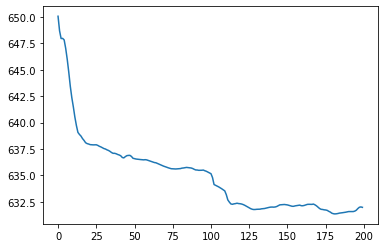

In [8]:
plt.plot(range(len(losses)), losses)

In [9]:
print(losses)
with open('./Results/DRO_Gaussian.npy', 'wb') as f:
    np.save(f, losses)

[array(650.05347115), array(648.66955182), array(647.94432325), array(647.96048551), array(647.81211911), array(647.01843908), array(645.98999752), array(644.77855325), array(643.44404944), array(642.35869151), array(641.48385608), array(640.51794292), array(639.71952259), array(639.06864414), array(638.87308587), array(638.71912604), array(638.48283835), array(638.30741755), array(638.0940021), array(638.00884454), array(637.96755997), array(637.91064073), array(637.90197946), array(637.88771851), array(637.89711237), array(637.89604759), array(637.83769326), array(637.753356), array(637.69494541), array(637.61137488), array(637.53903454), array(637.49529815), array(637.41665812), array(637.35845591), array(637.27035217), array(637.16145223), array(637.08929648), array(637.0901234), array(637.04743103), array(636.97886704), array(636.93100286), array(636.85578152), array(636.69590439), array(636.65594281), array(636.77634068), array(636.86815387), array(636.89075872), array(636.894017

In [10]:
with open('./Results/Gaussian_theta.npy', 'wb') as f:
    np.save(f, theta_sqrt_all.detach().numpy())
    np.save(f, theta_linear_all.detach().numpy())

In [11]:
#### actual
from gen_random_series import gen_random_series
seed = 1000
wind_series_batch, setpoint_series_batch = gen_random_series(Generators, stage_num, category, batch_size, seed)
true_value= 0
for i in range(batch_size):
    setpoint_series = setpoint_series_batch[i]
    wind_series = wind_series_batch[i]
    prob, _, _, _, _ = Conduct_Deterministic_T_stage_OPF(ppc_try, stage_num, penalty_info, setpoint_series, SOC_initial, demand_series, wind_series)
    true_value += prob.value
true_value = true_value/batch_size
print(true_value)

620.6338454487188
